 <span style="color: purple; font-weight: bold; font-size:26px"> Check if any models performs better than the naive classifier </span>


Let's start by importing some libs

In [1]:
# data analysis
import pandas as pd
import numpy as np
import random

# visualisations
import seaborn 
import matplotlib.pyplot as plt
%matplotlib inline

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
import pickle # for saving the model

# preprocesing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.impute import KNNImputer

# just out of curiosity
import time


Now, let's define some helper functions!


In [2]:
# let's define some helper functions:

def plot_models_acc(dict, naive_classifier):
    labels = tuple(dict.keys())
    y_pos = np.arange(len(labels))
    values = [dict[n]['accuracy'] for n in dict]
    fig, ax = plt.subplots()
    bars = ax.bar(y_pos, values, align='center', alpha=0.5)
    ax.set_xticks(y_pos)
    ax.set_xticklabels(labels,rotation='vertical')
    ax.set_ylabel('accuracy')
    ax.set_title('Accuracy of different models')
    # add a horizontal line at naive_classfier
    ax.axhline(y=naive_classifier, color='r', linestyle='-', label='Naive Classifier')
    ax.legend(loc='lower right')

    # Add percentage labels to the bars
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, value + 0.01, f'{value:.0%}', ha='center', va='bottom')

    # Add percentage label to the line
    ax.text(-0.1, naive_classifier + 0.01, f'{naive_classifier:.0%}', ha='right', va='bottom', color='r')

    plt.ylim((.40, .75))
    plt.show()
    
# checking the distribution of the features :)
def feature_dist(dataframe):
    col_num = len(dataframe.columns)
    from_to_ind = [(i, i+6) for i in range(0, col_num, 6)]

    for i, j in from_to_ind:
        if j >= col_num:
            if col_num - 1 == i:
                dataframe.iloc[:, i].hist(figsize=(11,11))
            else:
                dataframe.iloc[:, i:col_num-1].hist(layout=(1,col_num - 1 - i), figsize=(11,11))
        else:
            dataframe.iloc[:, i:j].hist(layout=(2,3), figsize=(11,11))
            
            
def conf_mat(grid_search: GridSearchCV, Y_test):
    # construction confusion matrix
    outcome_class_labels = ['Red', 'Draw', 'No contest', 'Blue']
    cm = confusion_matrix(
        Y_test, 
        grid_search.predict(X_test),
        labels = outcome_class_labels
    )

    # create heatmap
    seaborn.heatmap(
        cm, 
        annot=True, 
        cmap='Blues', 
        xticklabels=outcome_class_labels,
        yticklabels=outcome_class_labels,
        fmt='d')
    
    # add labels
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # print classification_report:
    print(classification_report(
        Y_test, 
        grid_search.predict(X_test), 
        target_names=outcome_class_labels,
        labels=outcome_class_labels,
        digits=4))

    return cm

### Importing data
Now, let's import the data.

The data is a result of a web-scraping script written in Python that visits websites like ufcstats.com and bestfightodds.com in order to gather, store and compute fighting statistics and odds. Our initial time period ranges from 2023 (most recent fights) to as far as 1994, but we have decided to skip the oldest 2400 fights. 

There are several reasons on why we skipped it. First and foremost, most of the oldest data has every winner labeled as 'Red' what would lead to the biased results of our model. Secondly, a lot of data was missing, especially data about the odds. Finally, fighting formulas have changed over time, therefore we would rather not to base our models on the 'outdated' information, so to speak.

Furthermore, let us mention that even in the selected time frame there are some missingness of the odds data that the scraper was unable to gather. Most of the times, it was because of the inconsistencies in the naming of fighters from the bestfightodds.com side. For example, one fighter could have 3 or 4 different pages simply because there were typos in names. To handle that, we manually mapped these odds into our datasets. In the main Excel file one may go and see the green-marked cells signifying the manual intervention. 


In [3]:
data = pd.read_excel('./UFCdata/datasets/UFC_fights_stats_complete.xlsx')
data = data.sort_values('Event_Date', ascending=True).reset_index(drop=True)
data = data.replace(['--', '---'], pd.NA)[2400:] 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4708 entries, 2400 to 7107
Columns: 224 entries, Unnamed: 0.1 to B_Closing_Odds
dtypes: bool(1), datetime64[ns](1), float64(138), int64(72), object(12)
memory usage: 8.0+ MB


In [5]:
data.describe()

,Unnamed: 0.1,Unnamed: 0,R_Height_cm,R_Weight_kg,R_Reach,R_Age,R_Total_Knockdowns,R_Total_Significant_Strikes_Attempted,R_Total_Significant_Strikes_Landed,R_Significant_Strikes_%_Landed,...,B_Opp_Significant_Strikes_in_Clinch_%_Landed,B_Opp_Average_Significant_Strikes_on_Ground_Attempted,B_Opp_Average_Significant_Strikes_on_Ground_Landed,B_Opp_Significant_Strikes_on_Ground_%_Landed,Number_of_Rounds,Last_Round_Duration,R_Open_Odds,B_Open_Odds,R_Closing_Odds,B_Closing_Odds
count,4708.000000,4708.000000,4708.000000,4708.000000,4624.000000,4708.000000,4708.000000,4708.000000,4708.000000,4708.000000,...,4708.000000,4708.00000,4708.000000,4708.000000,4708.000000,4708.000000,4708.000000,4708.000000,4708.000000,4708.000000
mean,3612.097281,3612.097281,177.486007,73.803455,182.092842,30.937128,1.967502,631.524851,279.340272,0.422360,...,0.522387,5.16545,3.596194,0.505321,2.429269,230.601742,-114.771453,37.722175,-137.179269,39.881903
std,2022.513871,2022.513871,9.244279,16.029015,11.308305,4.246129,2.727167,668.628788,291.850253,0.152530,...,0.320886,7.77080,5.448841,0.351317,1.006400,90.851972,223.974404,203.324964,302.604690,251.600065
min,31.000000,31.000000,152.400000,52.154195,147.320000,18.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,1.000000,5.000000,-2300.000000,-900.000000,-3500.000000,-1500.000000
25%,1900.750000,1900.750000,170.180000,61.224490,175.260000,28.000000,0.000000,146.000000,67.000000,0.382689,...,0.333333,0.00000,0.000000,0.000000,1.000000,158.000000,-230.000000,-150.000000,-265.000000,-155.000000
50%,3580.500000,3580.500000,177.800000,70.294785,182.880000,31.000000,1.000000,413.500000,184.000000,0.442389,...,0.633333,2.93750,2.000000,0.629630,3.000000,300.000000,-155.000000,125.000000,-152.000000,120.000000
75%,5392.250000,5392.250000,185.420000,83.900227,190.500000,34.000000,3.000000,905.250000,402.250000,0.503885,...,0.745532,7.00000,4.800000,0.765019,3.000000,300.000000,120.000000,175.000000,122.000000,200.000000
max,7096.000000,7096.000000,210.820000,120.181406,213.360000,46.000000,20.000000,6324.000000,2975.000000,1.000000,...,1.000000,141.00000,84.000000,1.000000,5.000000,300.000000,600.000000,1100.000000,775.000000,1000.000000


In [6]:
data.describe(include=['O'])

,Event_Name,Event_Location,Fight_Weight,Fight_Gender,R_Name,R_Stance,B_Name,B_Stance,Time_Format,Referee,Conclusion_Method,Winner
count,4708,4708,4708,4708,4708,4692,4708,4677,4708,4681,4708,4708
unique,401,137,10,2,1303,3,1471,3,3,164,10,4
top,UFC 286: Edwards vs. Usman 3,"Las Vegas, Nevada, USA",Lightweight,Male,Derrick Lewis,Orthodox,Angela Hill,Orthodox,3 Rnd (5-5-5),Herb Dean,Decision - Unanimous,Red
freq,15,1526,745,4056,20,3526,16,3421,4226,678,1755,2673


In [7]:
data.head()

,Unnamed: 0.1,Unnamed: 0,Event_Name,Event_Date,Event_Location,Fight_Weight,Fight_Title_Bout,Fight_Gender,R_Name,R_Height_cm,...,Number_of_Rounds,Last_Round_Duration,Time_Format,Referee,Conclusion_Method,Winner,R_Open_Odds,B_Open_Odds,R_Closing_Odds,B_Closing_Odds
2400,1120,1120,UFC 164: Henderson vs Pettis 2,2013-08-31,"Milwaukee, Wisconsin, USA",Flyweight,False,Male,Louis Gaudinot,160.02,...,3,300,3 Rnd (5-5-5),Herb Dean,Decision - Unanimous,Blue,120.0,-160.0,190.0,-240.0
2401,1126,1126,UFC 164: Henderson vs Pettis 2,2013-08-31,"Milwaukee, Wisconsin, USA",Heavyweight,False,Male,Frank Mir,190.50,...,1,116,3 Rnd (5-5-5),Rob Hinds,KO/TKO,Blue,170.0,-230.0,155.0,-185.0
2402,1124,1124,UFC 164: Henderson vs Pettis 2,2013-08-31,"Milwaukee, Wisconsin, USA",Featherweight,False,Male,Chad Mendes,167.64,...,3,30,3 Rnd (5-5-5),Yves Lavigne,KO/TKO,Red,-350.0,250.0,-500.0,375.0
2403,1123,1123,UFC 164: Henderson vs Pettis 2,2013-08-31,"Milwaukee, Wisconsin, USA",Heavyweight,False,Male,Ben Rothwell,193.04,...,3,114,3 Rnd (5-5-5),Herb Dean,KO/TKO,Red,-130.0,-110.0,-155.0,110.0
2404,1122,1122,UFC 164: Henderson vs Pettis 2,2013-08-31,"Milwaukee, Wisconsin, USA",Featherweight,False,Male,Erik Koch,177.80,...,3,300,3 Rnd (5-5-5),Rob Hinds,Decision - Unanimous,Blue,-140.0,100.0,-210.0,170.0


In [8]:
# shuffling the data before we proceed:
data = data.sample(frac=1, random_state=2023).reset_index(drop=True)

We further need to drop some of the columns that will not be of use. In this run, we include the closing odds.


In [9]:
dropdata = data.drop(['Unnamed: 0',
                      'Unnamed: 0.1',
                      'Event_Name',
                      'Event_Location',
                      'B_Name',
                      'R_Name',
                      'Conclusion_Method',
                      'Event_Date',
                      'Last_Round_Duration',
                      'Number_of_Rounds',
                      'Referee',
                      #'R_Closing_Odds', # we don't do that here
                      #'B_Closing_Odds'
                     ], axis=1)

Next, let's find numerical and categorical columns in our dataset. 

In [10]:
objecttypes_cat = list(dropdata.select_dtypes(include=['O']).columns)
objecttypes_num = list(dropdata.select_dtypes(include=['int64', 'float64']).columns)

# we don't want to one-hot encode 'Winner' since it's not really required
# and the pipeline breaks if we do (it'll be looking for this var in 
# X_train&X_test but it's obviously not there)
objecttypes_cat = [x for x in objecttypes_cat if x != 'Winner']

# Candidate models

We've chosen the following candidate models that we will further try to get the best performance from. In the end, we will present a comparison of each model.

#### - Perceptron
#### - Random Forests
#### - Decision Trees Classifier
#### - SGD Classifier
#### - Linear SVC
#### - Gaussian Naive Bayes
#### - KNN

PS.
Models can be loaded after they are saved. However, pay attention when loading them up after the kernel restart - loaded model may make predictions based on different training set. This means that it was partially trained on the current test set. It is due to the shuffling we make during train_test splitting.

In [11]:
tuned_models = dict()
outcome_class_labels = ['Red', 'Draw', 'No contest', 'Blue']

### Standardizing the data (based on X_train) and outputting the naive classifier for the test set:

In [12]:
# Set the random seed
random.seed(2137)
np.random.seed(2137)

Y_all = dropdata['Winner']
X_all = dropdata.drop(['Winner'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.25, random_state=2023)

# standardizer for numerical columns
transformer_num = Pipeline([
    ('scaler', StandardScaler())
])

# standardizer for categorical columns
transformer_cat = Pipeline([
    ('scaler', OneHotEncoder())
])

# jumping into using these into the preprocessor for all features:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', transformer_num, objecttypes_num),
        ('cat', transformer_cat, objecttypes_cat)   # no 'Winner' encoded
], remainder='passthrough')

# the standardization should be based on the training set, hence we obtain the relevant parameters:
x = preprocessor.fit_transform(X_train)

In [13]:
# printing the naive classifier on the test set
naive_classifier = Y_test.loc[Y_test == 'Red'].count() / Y_test.count()
print("The naive classifier accuracy in the test set is: ", naive_classifier)

The naive classifier accuracy in the test set is:  0.5548003398470688


The naive classifier that would be the least we should beat is the proportion of Red Winners to all fights outcomes, since it's the most common result. 

It appears that our models should be capable to achieve at least 55.5% accuracy to beat the naive classifier. It signifies that we do better than random guessing.

## Perceptron:

The Perceptron is another simple classification algorithm suitable for large scale learning. By default:

        It does not require a learning rate.

        It is not regularized (penalized).

        It updates its model only on mistakes.

The last characteristic implies that the Perceptron is slightly faster to train than SGD with the hinge loss and that the resulting models are sparser.

- Linearly separable

In [ ]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', KNNImputer()),
    ('selector', SelectKBest()),
    ('model', Perceptron(random_state=2023))
])


# Define the parameter grid
param_grid = {
    'selector__k': [8, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, len(preprocessor.get_feature_names_out())],
    'model__penalty': ['elasticnet', 'l2', 'l1', None],
    'model__alpha': [0.01, 0.001],
    'model__max_iter': [500, 1000, 1500],
    'model__tol': [0.1, 0.01, 0.001, 0.0001]
}

# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=3, verbose=2)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('trained_models/best_perceptron_model_closed_odds.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [14]:
# load the best model from disk using pickle
with open('trained_models/best_perceptron_model_closed_odds.pkl', 'rb') as f:
    model = pickle.load(f)

print('Best parameters after the grid search: ', model.best_params_)

Best parameters after the grid search:  {'model__alpha': 0.01, 'model__max_iter': 500, 'model__penalty': 'l1', 'model__tol': 0.1, 'selector__k': 25}


In [15]:
# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('Columns after feature selection: ', selected_feature_names)

Columns after feature selection:  ['num__R_Age' 'num__R_Losing_Streak'
 'num__R_Total_Number_of_Wins_By_Split_Decision'
 'num__R_Total_Number_of_Fights' 'num__R_Win_%'
 'num__R_Opp_Average_Knockdowns' 'num__R_Opp_Significant_Strikes_%_Landed'
 'num__R_Opp_Average_Strikes_Landed' 'num__R_Opp_Total_Strikes_%_Landed'
 'num__R_Opp_Average_Submission_Attempts' 'num__R_Opp_Average_Control'
 'num__R_Opp_Average_Significant_Strikes_on_Head_Landed'
 'num__R_Opp_Significant_Strikes_on_Head_%_Landed'
 'num__R_Opp_Significant_Strikes_on_Body_%_Landed'
 'num__R_Opp_Significant_Strikes_at_Distance_%_Landed'
 'num__R_Opp_Average_Significant_Strikes_on_Ground_Attempted'
 'num__R_Opp_Average_Significant_Strikes_on_Ground_Landed' 'num__B_Age'
 'num__B_Average_Takedowns_Landed'
 'num__B_Average_Significant_Strikes_on_Ground_Attempted'
 'num__B_Average_Significant_Strikes_on_Ground_Landed' 'num__R_Open_Odds'
 'num__B_Open_Odds' 'num__R_Closing_Odds' 'num__B_Closing_Odds']


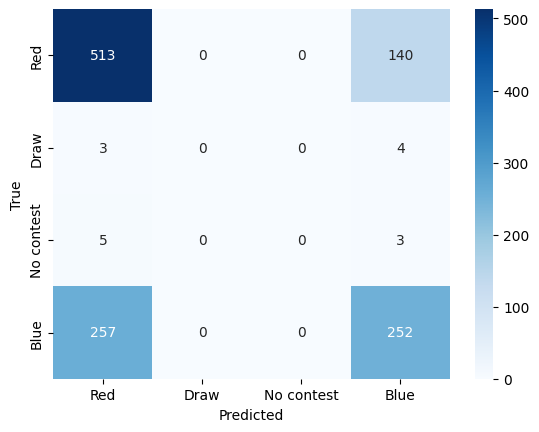

c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

         Red     0.6594    0.7856    0.7170       653
        Draw     0.0000    0.0000    0.0000         7
  No contest     0.0000    0.0000    0.0000         8
        Blue     0.6316    0.4951    0.5551       509

    accuracy                         0.6500      1177
   macro avg     0.3227    0.3202    0.3180      1177
weighted avg     0.6390    0.6500    0.6378      1177

Accuracy on the test set:  0.6499575191163977
Micro-average ROC_AUC_score: 0.89645155290428


In [16]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# evaluating micro-averaged AUC:
# The Perceptron() in sklearn doesn't offer the predict_proba() method, so we need to have workaround for that.
# It can be accomplished by the following:
calibrated_model = CalibratedClassifierCV(model.best_estimator_, cv='prefit')
calibrated_model.fit(X_train, Y_train)
# get predicted probabilities
Y_pred_prob = calibrated_model.predict_proba(X_test)

# Compute micro-average ROC AUC score
roc_auc_micro = roc_auc_score(Y_test, Y_pred_prob, multi_class='ovr', average='micro')

# store model results in tuned_models dictionary
print('Accuracy on the test set: ',acc_sco)
print('Micro-average ROC_AUC_score:', roc_auc_micro)
tuned_models['Perceptron'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

## Random Forest Classifier

A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

In [ ]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', KNNImputer()),
    ('selector', SelectKBest()),
    ('model', RandomForestClassifier(random_state=123))
])


# Define the parameter grid
param_grid = {
    'selector__k': [10, 30, 50, 80, 110, 150, len(preprocessor.get_feature_names_out())],
    'model__n_estimators': [100, 150, 200, 250, 300],
    'model__criterion': ['gini'],
    'model__max_depth': [None],
    'model__min_samples_split': [2, 3, 4],
    'model__min_samples_leaf': [2, 3, 4, 5, 6],
    'model__max_features': ['sqrt']
}

# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=4)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('trained_models/best_random_forest_model_closed_odds.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [17]:
# load the best model from disk using pickle
with open('trained_models/best_random_forest_model_closed_odds.pkl', 'rb') as f:
    model = pickle.load(f)
 
print('Best parameters after the grid search: ', model.best_params_)

Best parameters after the grid search:  {'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 250, 'selector__k': 30}


In [18]:
# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('\nColumns after feature selection: ', selected_feature_names)


Columns after feature selection:  ['num__R_Age' 'num__R_Total_Knockdowns'
 'num__R_Average_Significant_Strikes_on_Ground_Attempted'
 'num__R_Winning_Streak' 'num__R_Losing_Streak'
 'num__R_Total_Number_of_Wins_By_Split_Decision'
 'num__R_Total_Number_of_Fights' 'num__R_Win_%'
 'num__R_Opp_Average_Knockdowns' 'num__R_Opp_Significant_Strikes_%_Landed'
 'num__R_Opp_Average_Strikes_Landed' 'num__R_Opp_Total_Strikes_%_Landed'
 'num__R_Opp_Average_Submission_Attempts' 'num__R_Opp_Average_Control'
 'num__R_Opp_Average_Significant_Strikes_on_Head_Landed'
 'num__R_Opp_Significant_Strikes_on_Head_%_Landed'
 'num__R_Opp_Significant_Strikes_on_Body_%_Landed'
 'num__R_Opp_Significant_Strikes_at_Distance_%_Landed'
 'num__R_Opp_Average_Significant_Strikes_on_Ground_Attempted'
 'num__R_Opp_Average_Significant_Strikes_on_Ground_Landed' 'num__B_Age'
 'num__B_Average_Takedowns_Landed'
 'num__B_Average_Significant_Strikes_on_Ground_Attempted'
 'num__B_Average_Significant_Strikes_on_Ground_Landed'
 'num__

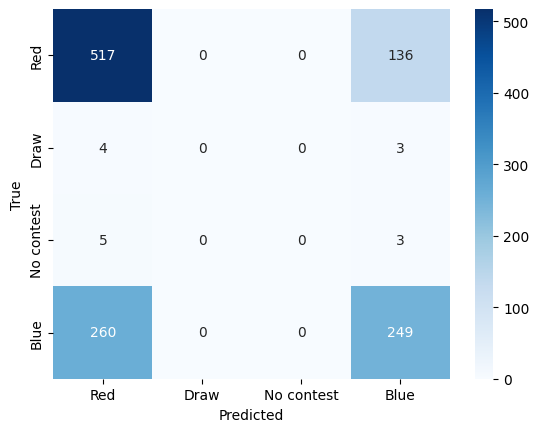

c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

         Red     0.6578    0.7917    0.7186       653
        Draw     0.0000    0.0000    0.0000         7
  No contest     0.0000    0.0000    0.0000         8
        Blue     0.6368    0.4892    0.5533       509

    accuracy                         0.6508      1177
   macro avg     0.3236    0.3202    0.3180      1177
weighted avg     0.6403    0.6508    0.6379      1177

Accuracy on the test set:  0.6508071367884452
Micro-average ROC_AUC_score: 0.8943093421610799


In [19]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# Compute micro-average ROC AUC score
Y_pred_prob = model.predict_proba(X_test)
roc_auc_micro = roc_auc_score(Y_test, Y_pred_prob, multi_class='ovr', average='micro')

# store model results in tuned_models dictionary
print('Accuracy on the test set: ',acc_sco)
print('Micro-average ROC_AUC_score:', roc_auc_micro)
tuned_models['Random_Forest'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

## Decision Tree Classifier

A decision tree classifier.

In [ ]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('Imputer', KNNImputer()),
    ('selector', SelectKBest()),
    ('model', DecisionTreeClassifier(random_state=2023))
])


# Define the parameter grid (k<5 check)
param_grid = {
    'selector__k': [3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 70, 90, len(preprocessor.get_feature_names_out())],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None, 4],
    'model__min_samples_split': [2,3,4,6,8,10],
    'model__min_samples_leaf': [1,2,3,4,6,8,10],
    'model__max_features': ['sqrt', None]
}

# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=4)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('trained_models/best_decision_tree_model_closed_odds.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [20]:
# load the best model from disk using pickle
with open('trained_models/best_decision_tree_model_closed_odds.pkl', 'rb') as f:
    model = pickle.load(f)
 
print('Best parameters after the grid search: ', model.best_params_)

Best parameters after the grid search:  {'model__criterion': 'gini', 'model__max_depth': 4, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 8, 'model__min_samples_split': 2, 'selector__k': 5}


In [21]:
# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('Columns after feature selection: ', selected_feature_names)

Columns after feature selection:  ['num__R_Age' 'num__R_Open_Odds' 'num__B_Open_Odds' 'num__R_Closing_Odds'
 'num__B_Closing_Odds']


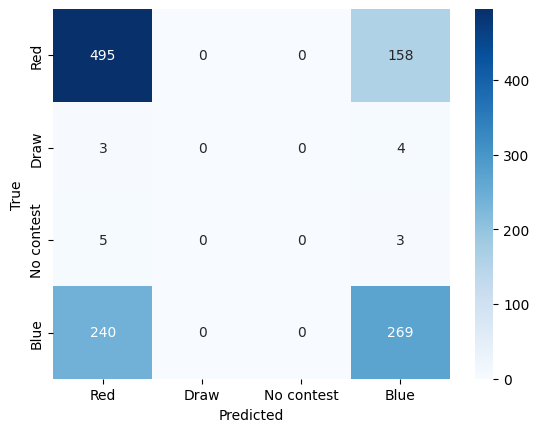

              precision    recall  f1-score   support

         Red     0.6662    0.7580    0.7092       653
        Draw     0.0000    0.0000    0.0000         7
  No contest     0.0000    0.0000    0.0000         8
        Blue     0.6198    0.5285    0.5705       509

    accuracy                         0.6491      1177
   macro avg     0.3215    0.3216    0.3199      1177
weighted avg     0.6377    0.6491    0.6402      1177

Accuracy on the test set:  0.64910790144435
Micro-average ROC_AUC_score: 0.89842473039497


c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [22]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# Compute micro-average ROC AUC score
Y_pred_prob = model.predict_proba(X_test)
roc_auc_micro = roc_auc_score(Y_test, Y_pred_prob, multi_class='ovr', average='micro')

# store model results in tuned_models dictionary
print('Accuracy on the test set: ',acc_sco)
print('Micro-average ROC_AUC_score:', roc_auc_micro)
tuned_models['Decision_Tree'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

## Stochastic Gradient Descent (SGD) Classifier

A linear classifier with SGD training. Default implementation uses the loss='hinge' used for linear SVM

In [ ]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', KNNImputer()),
    ('selector', SelectKBest()),
    ('model', SGDClassifier(random_state=2023))
])


# Define the parameter grid
param_grid = {
    'selector__k': [10, 20, 30, 40, 50, 70, 90, 150, len(preprocessor.get_feature_names_out())],
    'model__alpha': [0.1, 0.01, 0.001, 0.0001],
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__max_iter': [200, 500, 1000],
    'model__tol': [0.1, 0.01, 0.001, 0.0001]
}
# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=3)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('trained_models/best_SGDClassfier_model_closed_odds.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [23]:
# load the best model from disk using pickle
with open('trained_models/best_SGDClassfier_model_closed_odds.pkl', 'rb') as f:
    model = pickle.load(f)
 
print('Best parameters after the grid search: ', model.best_params_)

Best parameters after the grid search:  {'model__alpha': 0.1, 'model__max_iter': 200, 'model__penalty': 'elasticnet', 'model__tol': 0.001, 'selector__k': 30}


In [24]:
# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('Columns after feature selection: ', selected_feature_names)

Columns after feature selection:  ['num__R_Age' 'num__R_Total_Knockdowns'
 'num__R_Average_Significant_Strikes_on_Ground_Attempted'
 'num__R_Winning_Streak' 'num__R_Losing_Streak'
 'num__R_Total_Number_of_Wins_By_Split_Decision'
 'num__R_Total_Number_of_Fights' 'num__R_Win_%'
 'num__R_Opp_Average_Knockdowns' 'num__R_Opp_Significant_Strikes_%_Landed'
 'num__R_Opp_Average_Strikes_Landed' 'num__R_Opp_Total_Strikes_%_Landed'
 'num__R_Opp_Average_Submission_Attempts' 'num__R_Opp_Average_Control'
 'num__R_Opp_Average_Significant_Strikes_on_Head_Landed'
 'num__R_Opp_Significant_Strikes_on_Head_%_Landed'
 'num__R_Opp_Significant_Strikes_on_Body_%_Landed'
 'num__R_Opp_Significant_Strikes_at_Distance_%_Landed'
 'num__R_Opp_Average_Significant_Strikes_on_Ground_Attempted'
 'num__R_Opp_Average_Significant_Strikes_on_Ground_Landed' 'num__B_Age'
 'num__B_Average_Takedowns_Landed'
 'num__B_Average_Significant_Strikes_on_Ground_Attempted'
 'num__B_Average_Significant_Strikes_on_Ground_Landed'
 'num__B

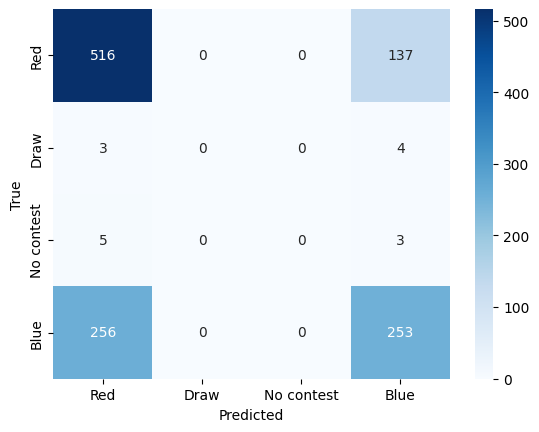

c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

         Red     0.6615    0.7902    0.7202       653
        Draw     0.0000    0.0000    0.0000         7
  No contest     0.0000    0.0000    0.0000         8
        Blue     0.6373    0.4971    0.5585       509

    accuracy                         0.6534      1177
   macro avg     0.3247    0.3218    0.3197      1177
weighted avg     0.6426    0.6534    0.6411      1177

Accuracy on the test set:  0.653355989804588
Micro-average ROC_AUC_score: 0.8979561293141677


In [25]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# Compute micro-average ROC AUC score
# The SGDClassifier() with loss = 'hinge' (for SVM) in sklearn doesn't offer the predict_proba() method, 
# so we need to have workaround for that.
# It can be accomplished by the following:
calibrated_model = CalibratedClassifierCV(model.best_estimator_, cv='prefit')
calibrated_model.fit(X_train, Y_train)
# get predicted probabilities
Y_pred_prob = calibrated_model.predict_proba(X_test)
roc_auc_micro = roc_auc_score(Y_test, Y_pred_prob, multi_class='ovr', average='micro')

# store model results in tuned_models dictionary
print('Accuracy on the test set: ',acc_sco)
print('Micro-average ROC_AUC_score:', roc_auc_micro)
tuned_models['SGDClassfier'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

## Linear SVC

Linear Support Vector Classification.

In [ ]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', KNNImputer()),
    ('selector', SelectKBest()),
    ('model', LinearSVC(random_state=2023))
])


# Define the parameter grid
param_grid = {
    'selector__k': [5, 10, 20, 40, 50, 60, 75, 90, 130, len(preprocessor.get_feature_names_out())],
    'model__loss': ['hinge'],
    'model__C': [10, 1, 0.1, 0.01, 0.001],
    'model__penalty': ['l2'],
    'model__max_iter': [500, 1000, 1500],
    'model__tol': [0.1, 0.01, 0.001, 0.0001, 0.00001]
}
# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=3)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('trained_models/best_LinearSVC_model_closed_odds.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [26]:
# load the best model from disk using pickle
with open('trained_models/best_LinearSVC_model_closed_odds.pkl', 'rb') as f:
    model = pickle.load(f)
 
print('Best parameters after the grid search: ', model.best_params_)

Best parameters after the grid search:  {'model__C': 0.001, 'model__loss': 'hinge', 'model__max_iter': 500, 'model__penalty': 'l2', 'model__tol': 0.0001, 'selector__k': 230}


In [27]:
# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('Columns after feature selection: ', selected_feature_names)

Columns after feature selection:  ['num__R_Height_cm' 'num__R_Weight_kg' 'num__R_Reach' 'num__R_Age'
 'num__R_Total_Knockdowns' 'num__R_Total_Significant_Strikes_Attempted'
 'num__R_Total_Significant_Strikes_Landed'
 'num__R_Significant_Strikes_%_Landed' 'num__R_Total_Strikes_Attempted'
 'num__R_Total_Strikes_Landed' 'num__R_Total_Strikes_%_Landed'
 'num__R_Total_Takedowns_Attempted' 'num__R_Total_Takedowns_Landed'
 'num__R_Takedowns_%_Landed' 'num__R_Total_Submission_Attempts'
 'num__R_Total_Reversals' 'num__R_Total_Control'
 'num__R_Total_Significant_Strikes_on_Head_Attempted'
 'num__R_Total_Significant_Strikes_on_Head_Landed'
 'num__R_Significant_Strikes_on_Head_%_Landed'
 'num__R_Total_Significant_Strikes_on_Body_Attempted'
 'num__R_Total_Significant_Strikes_on_Body_Landed'
 'num__R_Significant_Strikes_on_Body_%_Landed'
 'num__R_Total_Significant_Strikes_on_Leg_Attempted'
 'num__R_Total_Significant_Strikes_on_Leg_Landed'
 'num__R_Significant_Strikes_on_Leg_%_Landed'
 'num__R_Total_

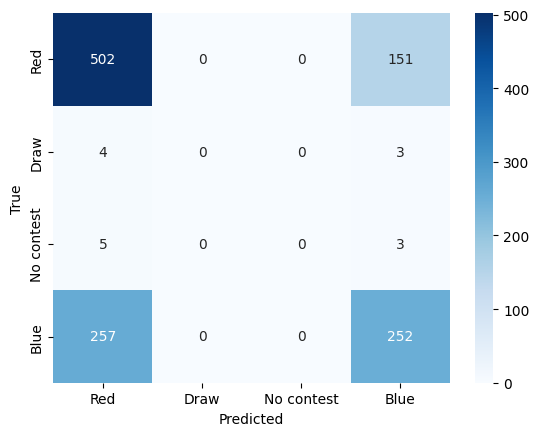

c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

         Red     0.6536    0.7688    0.7065       653
        Draw     0.0000    0.0000    0.0000         7
  No contest     0.0000    0.0000    0.0000         8
        Blue     0.6161    0.4951    0.5490       509

    accuracy                         0.6406      1177
   macro avg     0.3174    0.3160    0.3139      1177
weighted avg     0.6291    0.6406    0.6294      1177

Accuracy on the test set:  0.6406117247238743
Micro-average ROC_AUC_score: 0.8963346131737178


In [28]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# The LinearSVC() in sklearn doesn't offer the predict_proba() method, so we need to have workaround for that.
# It can be accomplished by the following:
calibrated_model = CalibratedClassifierCV(model.best_estimator_, cv='prefit')
calibrated_model.fit(X_train, Y_train)
# get predicted probabilities
Y_pred_prob = calibrated_model.predict_proba(X_test)
roc_auc_micro = roc_auc_score(Y_test, Y_pred_prob, multi_class='ovr', average='micro')

# store model results in tuned_models dictionary
print('Accuracy on the test set: ',acc_sco)
print('Micro-average ROC_AUC_score:', roc_auc_micro)
tuned_models['LinearSVC'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

## Gaussian Naive Bayes

Gaussian Naive Bayes (GaussianNB)

In [ ]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', KNNImputer()),
    ('selector', SelectKBest()),
    ('model', GaussianNB())
])


# Define the parameter grid
param_grid = {
    'selector__k': [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 120, 150, len(preprocessor.get_feature_names_out())],
}
# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('trained_models/best_GaussianNB_model_closed_odds.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [29]:
# load the best model from disk using pickle
with open('trained_models/best_GaussianNB_model_closed_odds.pkl', 'rb') as f:
    model = pickle.load(f)
 
print('Best parameters after the grid search: ', model.best_params_)

Best parameters after the grid search:  {'selector__k': 1}


In [30]:
# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('Columns after feature selection: ', selected_feature_names)

Columns after feature selection:  ['num__B_Closing_Odds']


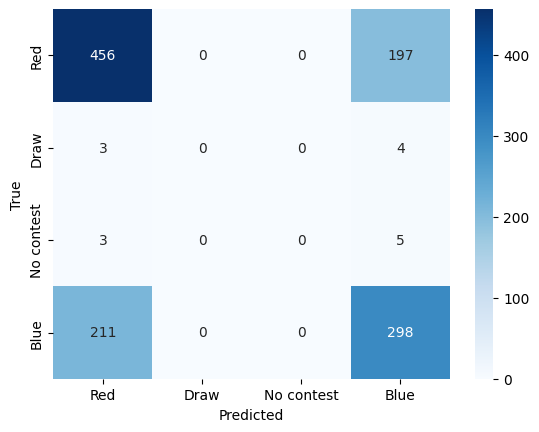

              precision    recall  f1-score   support

         Red     0.6776    0.6983    0.6878       653
        Draw     0.0000    0.0000    0.0000         7
  No contest     0.0000    0.0000    0.0000         8
        Blue     0.5913    0.5855    0.5884       509

    accuracy                         0.6406      1177
   macro avg     0.3172    0.3209    0.3190      1177
weighted avg     0.6316    0.6406    0.6360      1177

Accuracy on the test set:  0.6406117247238743
Micro-average ROC_AUC_score: 0.8948293149136415


c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [31]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# Compute micro-average ROC AUC score
Y_pred_prob = model.predict_proba(X_test)
roc_auc_micro = roc_auc_score(Y_test, Y_pred_prob, multi_class='ovr', average='micro')

# store model results in tuned_models dictionary
print('Accuracy on the test set: ',acc_sco)
print('Micro-average ROC_AUC_score:', roc_auc_micro)
tuned_models['Gaussian_NB'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

## KNN

Classifier implementing the k-nearest neighbors vote.

In [ ]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', KNNImputer()),
    ('selector', SelectKBest()),
    ('model', KNeighborsClassifier())
])


# Define the parameter grid
param_grid = {
    'selector__k': [5, 10, 15, 20, 30, 40, 50, 60, 90, 140, len(preprocessor.get_feature_names_out())],
    'model__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan', 'minkowski']
}
# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=3)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('trained_models/best_KNN_model_closed_odds.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [32]:
# load the best model from disk using pickle
with open('trained_models/best_KNN_model_closed_odds.pkl', 'rb') as f:
    model = pickle.load(f)
 
print('Best parameters after the grid search: ', model.best_params_)

Best parameters after the grid search:  {'model__metric': 'manhattan', 'model__n_neighbors': 15, 'model__weights': 'uniform', 'selector__k': 30}


In [33]:
# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('Columns after feature selection: ', selected_feature_names)

Columns after feature selection:  ['num__R_Age' 'num__R_Total_Knockdowns'
 'num__R_Average_Significant_Strikes_on_Ground_Attempted'
 'num__R_Winning_Streak' 'num__R_Losing_Streak'
 'num__R_Total_Number_of_Wins_By_Split_Decision'
 'num__R_Total_Number_of_Fights' 'num__R_Win_%'
 'num__R_Opp_Average_Knockdowns' 'num__R_Opp_Significant_Strikes_%_Landed'
 'num__R_Opp_Average_Strikes_Landed' 'num__R_Opp_Total_Strikes_%_Landed'
 'num__R_Opp_Average_Submission_Attempts' 'num__R_Opp_Average_Control'
 'num__R_Opp_Average_Significant_Strikes_on_Head_Landed'
 'num__R_Opp_Significant_Strikes_on_Head_%_Landed'
 'num__R_Opp_Significant_Strikes_on_Body_%_Landed'
 'num__R_Opp_Significant_Strikes_at_Distance_%_Landed'
 'num__R_Opp_Average_Significant_Strikes_on_Ground_Attempted'
 'num__R_Opp_Average_Significant_Strikes_on_Ground_Landed' 'num__B_Age'
 'num__B_Average_Takedowns_Landed'
 'num__B_Average_Significant_Strikes_on_Ground_Attempted'
 'num__B_Average_Significant_Strikes_on_Ground_Landed'
 'num__B

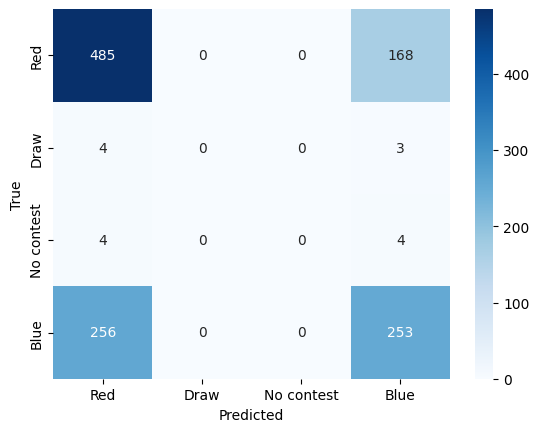

              precision    recall  f1-score   support

         Red     0.6475    0.7427    0.6919       653
        Draw     0.0000    0.0000    0.0000         7
  No contest     0.0000    0.0000    0.0000         8
        Blue     0.5911    0.4971    0.5400       509

    accuracy                         0.6270      1177
   macro avg     0.3097    0.3099    0.3080      1177
weighted avg     0.6149    0.6270    0.6174      1177

Accuracy on the test set:  0.627017841971113
Micro-average ROC_AUC_score: 0.886160014456253


c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [34]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# Compute micro-average ROC AUC score
Y_pred_prob = model.predict_proba(X_test)
roc_auc_micro = roc_auc_score(Y_test, Y_pred_prob, multi_class='ovr', average='micro')

# store model results in tuned_models dictionary
print('Accuracy on the test set: ',acc_sco)
print('Micro-average ROC_AUC_score:', roc_auc_micro)
tuned_models['KNN'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

## Logistic Regression

Logistic Regression (aka logit, MaxEnt) classifier.


In [ ]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', KNNImputer()),
    ('selector', SelectKBest()),
    ('model', LogisticRegression(random_state=2023))
])


# Define the parameter grid
param_grid = {
    'selector__k': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 140, len(preprocessor.get_feature_names_out())],
    'model__penalty': ['l2'],
    'model__C': [0.01, 0.1, 1.0],
    'model__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'model__max_iter': [50, 100, 150, 200, 300],
    'model__tol': [0.001, 0.0001, 0.00001]
}
# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=3)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('trained_models/best_logistic_regression_closed_odds.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [35]:
# load the best model from disk using pickle
with open('trained_models/best_logistic_regression_closed_odds.pkl', 'rb') as f:
    model = pickle.load(f)
 
print('Best parameters after the grid search: ', model.best_params_)

Best parameters after the grid search:  {'model__C': 1.0, 'model__max_iter': 50, 'model__penalty': 'l2', 'model__solver': 'lbfgs', 'model__tol': 0.001, 'selector__k': 20}


In [36]:
# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('Columns after feature selection: ', selected_feature_names)

Columns after feature selection:  ['num__R_Age' 'num__R_Losing_Streak'
 'num__R_Total_Number_of_Wins_By_Split_Decision'
 'num__R_Total_Number_of_Fights' 'num__R_Win_%'
 'num__R_Opp_Average_Knockdowns' 'num__R_Opp_Significant_Strikes_%_Landed'
 'num__R_Opp_Total_Strikes_%_Landed'
 'num__R_Opp_Average_Submission_Attempts' 'num__R_Opp_Average_Control'
 'num__R_Opp_Significant_Strikes_on_Head_%_Landed'
 'num__R_Opp_Average_Significant_Strikes_on_Ground_Attempted'
 'num__R_Opp_Average_Significant_Strikes_on_Ground_Landed' 'num__B_Age'
 'num__B_Average_Significant_Strikes_on_Ground_Attempted'
 'num__B_Average_Significant_Strikes_on_Ground_Landed' 'num__R_Open_Odds'
 'num__B_Open_Odds' 'num__R_Closing_Odds' 'num__B_Closing_Odds']


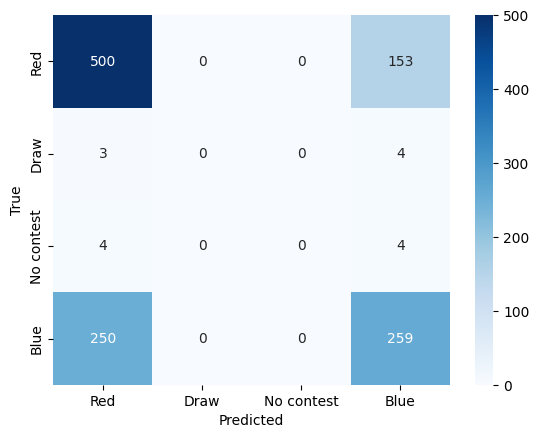

              precision    recall  f1-score   support

         Red     0.6605    0.7657    0.7092       653
        Draw     0.0000    0.0000    0.0000         7
  No contest     0.0000    0.0000    0.0000         8
        Blue     0.6167    0.5088    0.5576       509

    accuracy                         0.6449      1177
   macro avg     0.3193    0.3186    0.3167      1177
weighted avg     0.6331    0.6449    0.6346      1177

Accuracy on the test set:  0.6448598130841121
Micro-average ROC_AUC_score: 0.8959703194451764


c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [37]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# Compute micro-average ROC AUC score
Y_pred_prob = model.predict_proba(X_test)
roc_auc_micro = roc_auc_score(Y_test, Y_pred_prob, multi_class='ovr', average='micro')

# store model results in tuned_models dictionary
print('Accuracy on the test set: ',acc_sco)
print('Micro-average ROC_AUC_score:', roc_auc_micro)
tuned_models['Logistic_Regression'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

# FINAL TUNEL MODELS COMPARISON

Here we assess the performance of each model


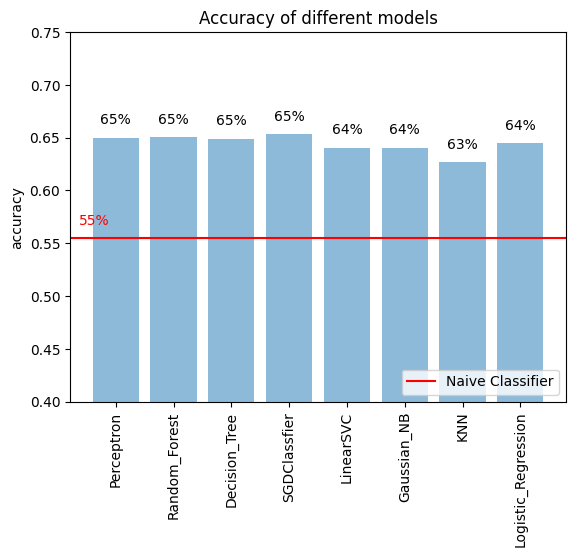

In [38]:
plot_models_acc(tuned_models, naive_classifier)

# NOTES

If the odds are available before the fight, then there is nothing inherently wrong with using them as a predictor. However, it's important to keep in mind that any information used for prediction should be available at the time the prediction is made. If the model is trained on data that includes information (such as odds) that would not be available at the time of prediction, then the model may overfit to the training data and perform poorly on new, unseen data.

Additionally, it's important to consider the ethics of using betting odds for predictive modeling. While it may be legal to use this information for research purposes, it could be seen as promoting gambling or taking advantage of vulnerable populations. It's important to approach this type of research with sensitivity and to consider the potential impacts of the research on society.